In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


#**Download Dataset**


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ismailnasri20_driver_drowsiness_dataset_ddd_path = kagglehub.dataset_download('ismailnasri20/driver-drowsiness-dataset-ddd')

print('Data source import complete.')


100%|██████████| 2.58G/2.58G [02:03<00:00, 22.5MB/s]

Extracting files...


#**Imports**



In [28]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from google.colab import files
import matplotlib.pyplot as plt
import kagglehub

In [5]:
ismailnasri20_driver_drowsiness_dataset_ddd_path = kagglehub.dataset_download('ismailnasri20/driver-drowsiness-dataset-ddd')
print("Dataset path:", ismailnasri20_driver_drowsiness_dataset_ddd_path)
print("Contents:", os.listdir(ismailnasri20_driver_drowsiness_dataset_ddd_path))

Dataset path: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1
Contents: ['Driver Drowsiness Dataset (DDD)']


In [6]:
def load_data(image_folder, img_size=(64, 64)):
    classes = {"Drowsy": 1, "Non Drowsy": 0}
    X, y = [], []

    base_folder = os.path.join(image_folder, "Driver Drowsiness Dataset (DDD)")
    print("Base folder:", base_folder)
    print("Base folder contents:", os.listdir(base_folder))

    for class_name in classes:
        class_dir = os.path.join(base_folder, class_name)
        try:
            images = os.listdir(class_dir)
            for img_name in images:
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(classes[class_name])
        except FileNotFoundError:
            print(f"Folder not found: {class_dir}")
            continue

    X = np.array(X)
    y = to_categorical(y)
    return X, y

In [7]:
# تحميل البيانات
dataset_path = ismailnasri20_driver_drowsiness_dataset_ddd_path
X, y = load_data(dataset_path)

Base folder: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)
Base folder contents: ['Drowsy', 'Non Drowsy']


In [8]:
# تقسيم البيانات
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
datagen.fit(X_train)

In [29]:
# بناء النموذج
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)


In [34]:

# 2. ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [35]:
# 3. ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [36]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9959 - loss: 0.0151
Epoch 1: val_accuracy improved from -inf to 0.99904, saving model to best_model.keras
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 58s 55ms/step - accuracy: 0.9959 - loss: 0.0151 - val_accuracy: 0.9990 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 2/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9943 - loss: 0.0180
Epoch 2: val_accuracy did not improve from 0.99904
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.9943 - loss: 0.0180 - val_accuracy: 0.9911 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 3/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9954 - loss: 0.0158
Epoch 3: val_accuracy improved from 0.99904 to 0.99928, saving model to best_model.keras
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.9954 - loss: 0.0158 - val_accuracy: 0.9993 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.995

In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,878,024 (18.61 MB)

 Trainable params: 1,625,858 (6.20 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 3,251,718 (12.40 MB)

In [38]:
# Save
model.save('driverr_drowsiness_best_model.keras')

In [39]:
loadedModel = load_model('driverr_drowsiness_best_model.keras')

In [40]:
from tensorflow.keras.models import load_model
from google.colab import files
loadedModel = load_model('driverr_drowsiness_best_model.keras')

def process_and_predict():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = cv2.imread(filename)
        if img is None:
            print("Error: Could not load the image. Please try another file.")
            return

        img_resized = cv2.resize(img, (64, 64))
        img_input = np.expand_dims(img_resized, axis=0)

        prediction = loadedModel.predict(img_input)
        class_names = ["Non Drowsy", "Drowsy"]
        predicted_class = class_names[np.argmax(prediction)]

        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 4))
        plt.imshow(img_rgb)
        plt.title(f"Predicted class: {predicted_class}", fontsize=12, pad=10)
        plt.axis('off')
        plt.show()

Saving 618abc9cdfbae01bc36d2ce5_hero_advanced_drowsiness.jpg to 618abc9cdfbae01bc36d2ce5_hero_advanced_drowsiness (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


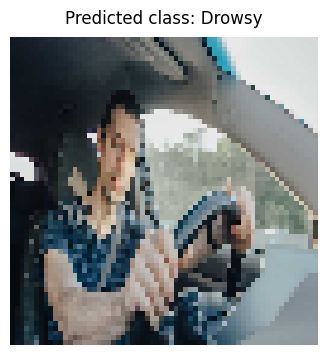

In [41]:
process_and_predict()

Saving Drowsy-Driving (1).jpg to Drowsy-Driving (1) (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


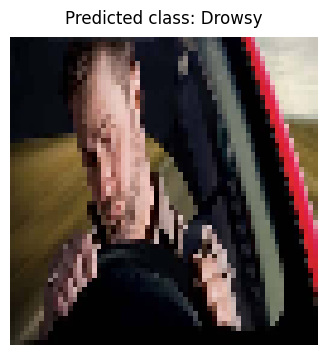

In [42]:
process_and_predict()

Saving 2-min-scaled.jpg to 2-min-scaled (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


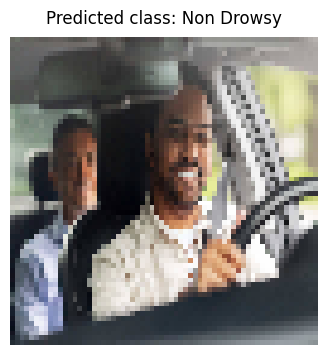

In [43]:
process_and_predict()

Saving man-driving-car-700x400.jpg to man-driving-car-700x400 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


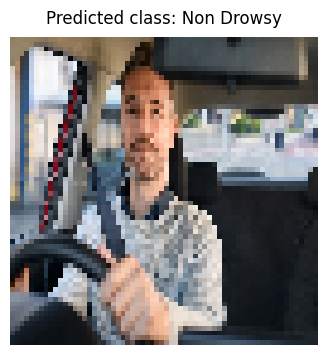

In [44]:
process_and_predict()

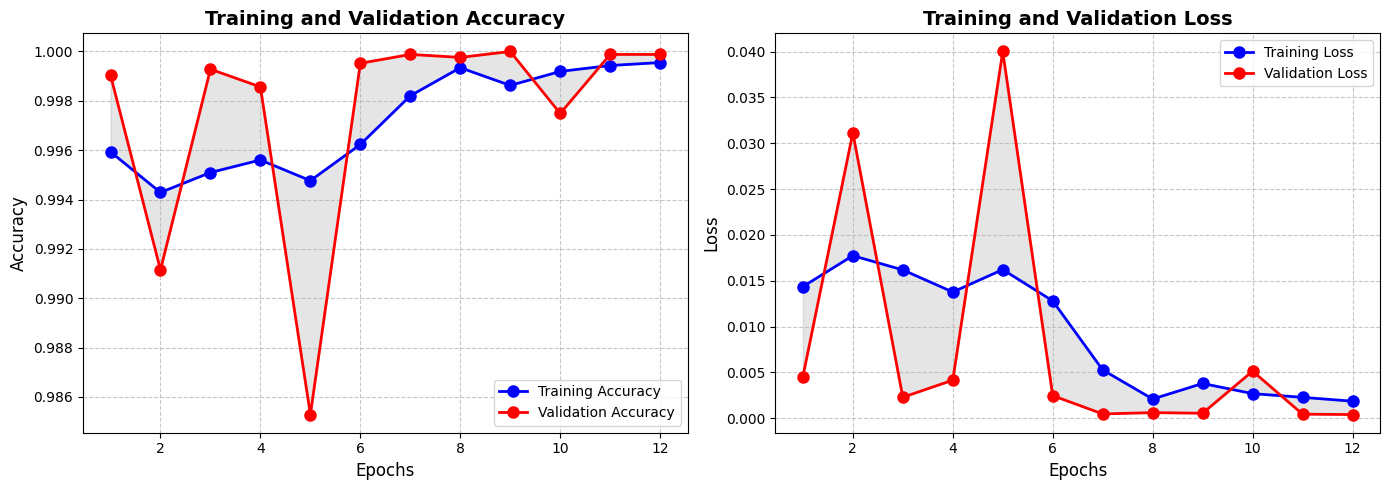

In [46]:
def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy', linewidth=2, markersize=8)
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy', linewidth=2, markersize=8)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', fontsize=10)
    plt.fill_between(epochs, acc, val_acc, color='gray', alpha=0.2)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss', linewidth=2, markersize=8)
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss', linewidth=2, markersize=8)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=10)
    plt.fill_between(epochs, loss, val_loss, color='gray', alpha=0.2)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# **Haneen Reda Ibrahim Zehry**
# **4211253**